In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB2, ResNet50, MobileNetV2

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
import os
from pathlib import Path

# 1. Importing the data

### 1.1 The Original Data

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)

In [6]:
root_dir = Path('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Images_Split')

train_dir = root_dir/'Train'
val_dir = root_dir/'Validation'
test_dir = root_dir/'Test'

train_dir, val_dir, test_dir

(WindowsPath('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Images_Split/Train'),
 WindowsPath('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Images_Split/Validation'),
 WindowsPath('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Images_Split/Test'))

In [7]:
train_ds = image_dataset_from_directory(directory=train_dir,
                                       label_mode='categorical',
                                       batch_size=BATCH_SIZE,
                                       image_size=IMG_SIZE,
                                       shuffle=True)
val_ds = image_dataset_from_directory(directory=val_dir,
                                     label_mode='categorical',
                                     batch_size=BATCH_SIZE,
                                     image_size=IMG_SIZE,
                                     shuffle=False)
test_ds = image_dataset_from_directory(directory=test_dir,
                                     label_mode='categorical',
                                     batch_size=BATCH_SIZE,
                                     image_size=IMG_SIZE,
                                     shuffle=False)
class_names = train_ds.class_names
print('\n')
print(f'Available classes are {class_names} \n')

class_to_idx = {class_name:idx for idx,class_name in enumerate(class_names)}
print(f'Class to id: {class_to_idx} \n')

Found 1088 files belonging to 4 classes.
Found 137 files belonging to 4 classes.
Found 138 files belonging to 4 classes.


Available classes are ['Burn Through', 'Lack of Penetration', 'Porosity', 'Undercut'] 

Class to id: {'Burn Through': 0, 'Lack of Penetration': 1, 'Porosity': 2, 'Undercut': 3} 



In [8]:
num_classes = len(class_names)
num_classes

4

### 1.2 The Augmented Dataset

In [9]:
root_dir_aug = Path('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Roboflow Split')

train_dir_aug = root_dir_aug/'Train'
print(f'Directorry of of augmented training set: {train_dir_aug}')

Directorry of of augmented training set: C:\Users\Sadat Iqbal\Desktop\Dhar Sir Thesis\Weld Data\Roboflow Split\Train


In [10]:
train_ds_aug = image_dataset_from_directory(directory=train_dir_aug,
                                           label_mode='categorical',
                                           batch_size=BATCH_SIZE,
                                           image_size=IMG_SIZE,
                                           shuffle=True)

Found 2688 files belonging to 4 classes.


### 1.3 further imports

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers

### 1.4 Creating a file to save experiment logs

In [12]:
os.makedirs('Publication_Exp_Logs', exist_ok=True)

# 2. ResNet50 Experiments

In [13]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [14]:
res50_train_ds = train_ds.map(lambda x,y: (preprocess_input(x),y))
res50_train_ds_aug = train_ds_aug.map(lambda x,y: (preprocess_input(x),y))

res50_val_ds = val_ds.map(lambda x,y: (preprocess_input(x),y))
res50_test_ds = test_ds.map(lambda x,y: (preprocess_input(x),y))

In [15]:
#building the ResNet50 model
def create_res50_model():
    base_model = ResNet50(weights = 'imagenet',
                          include_top=False,
                         input_shape=(224,224,3))
    base_model.trainable = False #No gradient tracking for feature extractor

    #proceeding using functional API
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(num_classes, activation = 'softmax')(x)

    model = Model(inputs = base_model.input, outputs = output)

    #setting gradient tracking on for the final dense layer on
    for layer in model.layers[:-1]:
        layer.trainable = False
    model.layers[-1].trainable = True

    return model
    

In [16]:
#importing the scheduler and creating the condition
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    if epoch <=10:
        return lr
    else:
        return 1e-4

#experimental setting
num_epochs = [5,10,15]
train_data = {'Original Data':res50_train_ds,
             'Augmented Data':res50_train_ds_aug}

### Training 🔥🔥🔥

In [17]:
#setting up a random seed
tf.random.set_seed(42)

#storing the results in an empty dict
exp_results = {}

for ds_name, train_ds in train_data.items():

    for epoch in num_epochs:

        #building the model
        model = create_res50_model()
        model_name = 'ResNet50'

        #compiling the model
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        criterion = tf.keras.losses.CategoricalCrossentropy()
        model.compile(optimizer = optimizer,
                     loss = criterion,
                     metrics = ['accuracy'])
        
        #adding a conditional lr_scheduler callback
        callbacks = []
        if epoch > 10:
            callbacks.append(LearningRateScheduler(lr_scheduler))

        #fitting the model
        history = model.fit(train_ds,
                           validation_data = res50_val_ds,
                           epochs = epoch,
                           callbacks = callbacks,
                           verbose = 2)

        #creating logs
        exp_id = f"{model_name}_{ds_name}_{epoch}epochs"

        exp_results[exp_id] = {'Train Loss': history.history['loss'],
                              'Validation Loss': history.history['val_loss'],
                              'Train Accuracy': history.history['accuracy'],
                              "Validation Accuracy": history.history['val_accuracy']}
        print(f'Finished training {exp_id}')
        print('-'*50+'\n')


#Saving results
import pickle
with open('Publication_Exp_Logs/Res50_exp_logs.pkl', 'wb') as f:
    pickle.dump(exp_results,f)

print("All experiments completed... And logged...")        

Epoch 1/5
34/34 - 11s - loss: 0.7020 - accuracy: 0.7298 - val_loss: 0.3423 - val_accuracy: 0.8759 - 11s/epoch - 310ms/step
Epoch 2/5
34/34 - 6s - loss: 0.2613 - accuracy: 0.9072 - val_loss: 0.2900 - val_accuracy: 0.8832 - 6s/epoch - 185ms/step
Epoch 3/5
34/34 - 6s - loss: 0.1892 - accuracy: 0.9375 - val_loss: 0.2095 - val_accuracy: 0.9124 - 6s/epoch - 184ms/step
Epoch 4/5
34/34 - 6s - loss: 0.1532 - accuracy: 0.9540 - val_loss: 0.1985 - val_accuracy: 0.9197 - 6s/epoch - 183ms/step
Epoch 5/5
34/34 - 6s - loss: 0.1232 - accuracy: 0.9660 - val_loss: 0.1816 - val_accuracy: 0.9343 - 6s/epoch - 184ms/step
Finished training ResNet50_Original Data_5epochs
--------------------------------------------------

Epoch 1/10
34/34 - 9s - loss: 0.8868 - accuracy: 0.6645 - val_loss: 0.3661 - val_accuracy: 0.8832 - 9s/epoch - 277ms/step
Epoch 2/10
34/34 - 6s - loss: 0.2963 - accuracy: 0.9053 - val_loss: 0.2926 - val_accuracy: 0.9124 - 6s/epoch - 185ms/step
Epoch 3/10
34/34 - 6s - loss: 0.2163 - accuracy:

# 3. EfficientNetB0 experiments

In [18]:
from tensorflow.keras.applications.efficientnet import preprocess_input

In [19]:
print(preprocess_input.__module__)

keras.applications.efficientnet


In [20]:
effnetb0_train_ds = train_ds.map(lambda x,y: (preprocess_input(x),y))
effnetb0_train_ds_aug = train_ds_aug.map(lambda x,y: (preprocess_input(x),y))

effnetb0_val_ds = val_ds.map(lambda x,y: (preprocess_input(x),y))
effnetb0_test_ds = test_ds.map(lambda x,y: (preprocess_input(x),y))

### the EfficientNetB0 function

In [21]:
def create_effnetb0_model():
    base_model = EfficientNetB0(weights = 'imagenet',
                               include_top = False,
                               input_shape = (224,224,3))
    for layer in base_model.layers:
        layer.trainable = False

    input = base_model.input
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(num_classes, activation = 'softmax')(x)

    model = Model(inputs = input, outputs = output)

    #turning gradient tracking on explicitly for the added layers
    for layer in model.layers[-3:]:
        layer.trainable = True

    return model
    

In [22]:
#importing the scheduler and creating the condition
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    if epoch <=10:
        return lr
    else:
        return 1e-4

#experimental setting
num_epochs = [5,10,15]
train_data = {'Original Data':effnetb0_train_ds,
             'Augmented Data':effnetb0_train_ds_aug}

### Training🔥🔥🔥

In [23]:
#setting up a random seed
tf.random.set_seed(42)

#storing the results in an empty dict
exp_results = {}

for ds_name, train_ds in train_data.items():

    for epoch in num_epochs:

        #building the model
        model = create_effnetb0_model()
        model_name = 'EfficientNetB0'

        #compiling the model
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        criterion = tf.keras.losses.CategoricalCrossentropy()
        model.compile(optimizer = optimizer,
                     loss = criterion,
                     metrics = ['accuracy'])
        
        #adding a conditional lr_scheduler callback
        callbacks = []
        if epoch > 10:
            callbacks.append(LearningRateScheduler(lr_scheduler))

        #fitting the model
        history = model.fit(train_ds,
                           validation_data = effnetb0_val_ds,
                           epochs = epoch,
                           callbacks = callbacks,
                           verbose = 1)

        #creating logs
        exp_id = f"{model_name}_{ds_name}_{epoch}epochs"

        exp_results[exp_id] = {'Train Loss': history.history['loss'],
                              'Validation Loss': history.history['val_loss'],
                              'Train Accuracy': history.history['accuracy'],
                              "Validation Accuracy": history.history['val_accuracy']}
        print(f'Finished training {exp_id}')
        print('-'*50+'\n')


#Saving results
import pickle
with open('Publication_Exp_Logs/Effnetb0_exp_logs.pkl', 'wb') as f:
    pickle.dump(exp_results,f)

print("All experiments completed... And logged...")        

Epoch 1/5
84/84 [==============================] - 10s 65ms/step - loss: 0.8295 - accuracy: 0.6682 - val_loss: 1.1630 - val_accuracy: 0.5182
Epoch 2/5
84/84 [==============================] - 5s 54ms/step - loss: 0.5548 - accuracy: 0.7920 - val_loss: 1.1401 - val_accuracy: 0.5693
Epoch 3/5
84/84 [==============================] - 5s 52ms/step - loss: 0.4875 - accuracy: 0.8132 - val_loss: 1.0556 - val_accuracy: 0.6058
Epoch 4/5
84/84 [==============================] - 5s 52ms/step - loss: 0.4411 - accuracy: 0.8304 - val_loss: 1.0377 - val_accuracy: 0.5912
Epoch 5/5
84/84 [==============================] - 5s 52ms/step - loss: 0.3945 - accuracy: 0.8601 - val_loss: 1.0912 - val_accuracy: 0.5912
Finished training EfficientNetB0_Original Data_5epochs
--------------------------------------------------

Epoch 1/10
84/84 [==============================] - 10s 65ms/step - loss: 0.8276 - accuracy: 0.6663 - val_loss: 1.0136 - val_accuracy: 0.5693
Epoch 2/10
84/84 [==============================] 

# 4. EfficientNetB2 experiments

### The EfficientNetB2 Function

In [24]:
def create_effnetb2_model():
    base_model = EfficientNetB2(weights = 'imagenet',
                               include_top = False,
                               input_shape = (260,260,3))
    for layer in base_model.layers:
        layer.trainable = False

    input = base_model.input
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation = 'softmax')(x)

    model = Model(inputs = input, outputs = output)

    #turning gradient tracking on explicitly for the added layers
    for layer in model.layers[-3:]:
        layer.trainable = True

    return model
    

### Defining appropraite transforms/preprocessing steps for EffnetB2

In [25]:
from tensorflow.keras.applications.efficientnet import preprocess_input as effnetb2_preprocess

effnetb2_transforms = tf.keras.models.Sequential([
    layers.Resizing(260,260,interpolation = 'bicubic'),
    layers.Lambda(effnetb2_preprocess)
])

In [26]:
effnetb2_train_ds = train_ds.map(lambda x, y: (effnetb2_transforms(x), y))
effnetb2_train_ds_aug = train_ds_aug.map(lambda x, y: (effnetb2_transforms(x), y))

effnetb2_val_ds = val_ds.map(lambda x, y: (effnetb2_transforms(x), y))
effnetb2_test_ds = test_ds.map(lambda x, y: (effnetb2_transforms(x), y))

In [27]:
#importing the scheduler and creating the condition
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    if epoch <=10:
        return lr
    else:
        return 1e-4

#experimental setting
num_epochs = [5,10,15]
train_data = {'Original Data':effnetb2_train_ds,
             'Augmented Data':effnetb2_train_ds_aug}

### Training 🔥🔥🔥

In [28]:
#setting up a random seed
tf.random.set_seed(42)

#storing the results in an empty dict
exp_results = {}

for ds_name, train_ds in train_data.items():

    for epoch in num_epochs:

        #building the model
        model = create_effnetb2_model()
        model_name = 'EfficientNetB2'

        #compiling the model
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        criterion = tf.keras.losses.CategoricalCrossentropy()
        model.compile(optimizer = optimizer,
                     loss = criterion,
                     metrics = ['accuracy'])
        
        #adding a conditional lr_scheduler callback
        callbacks = []
        if epoch > 10:
            callbacks.append(LearningRateScheduler(lr_scheduler))

        #fitting the model
        history = model.fit(train_ds,
                           validation_data = effnetb2_val_ds,
                           epochs = epoch,
                           callbacks = callbacks,
                           verbose = 1)

        #creating logs
        exp_id = f"{model_name}_{ds_name}_{epoch}epochs"

        exp_results[exp_id] = {'Train Loss': history.history['loss'],
                              'Validation Loss': history.history['val_loss'],
                              'Train Accuracy': history.history['accuracy'],
                              "Validation Accuracy": history.history['val_accuracy']}
        print(f'Finished training {exp_id}')
        print('-'*50+'\n')


#Saving results
import pickle
with open('Publication_Exp_Logs/Effnetb2_exp_logs.pkl', 'wb') as f:
    pickle.dump(exp_results,f)

print("All experiments completed... And logged...")        

Epoch 1/5
84/84 [==============================] - 16s 111ms/step - loss: 0.6203 - accuracy: 0.7902 - val_loss: 0.3169 - val_accuracy: 0.9270
Epoch 2/5
84/84 [==============================] - 8s 92ms/step - loss: 0.3036 - accuracy: 0.9062 - val_loss: 0.2290 - val_accuracy: 0.9489
Epoch 3/5
84/84 [==============================] - 8s 92ms/step - loss: 0.2388 - accuracy: 0.9260 - val_loss: 0.1993 - val_accuracy: 0.9343
Epoch 4/5
84/84 [==============================] - 8s 92ms/step - loss: 0.2103 - accuracy: 0.9342 - val_loss: 0.1693 - val_accuracy: 0.9270
Epoch 5/5
84/84 [==============================] - 8s 92ms/step - loss: 0.1861 - accuracy: 0.9408 - val_loss: 0.1663 - val_accuracy: 0.9343
Finished training EfficientNetB2_Original Data_5epochs
--------------------------------------------------

Epoch 1/10
84/84 [==============================] - 15s 111ms/step - loss: 0.6695 - accuracy: 0.7619 - val_loss: 0.3389 - val_accuracy: 0.9124
Epoch 2/10
84/84 [==============================

# 5. MobileNetV2 Experiments

### Defining appropriate transforms

In [29]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobile_preprocessing

#preprocessing/transform steps
steps = tf.keras.models.Sequential([
    layers.Resizing(232,232, interpolation = 'bilinear'),
    layers.CenterCrop(224,224),
    layers.Lambda(mobile_preprocessing)
    ])

#making it a function
def mobile_transforms(image, label):
   return steps(image), label

In [30]:
mobile_train_ds = train_ds.map(mobile_transforms)
mobile_train_ds_aug = train_ds_aug.map(mobile_transforms)

mobile_val_ds = val_ds.map(mobile_transforms)
mobile_test_ds = test_ds.map(mobile_transforms)

### The MobileNetV2 function

In [31]:
def create_mobilenetv2_model():
    base_model = MobileNetV2(weights='imagenet',
                            include_top=False,
                            input_shape=(224, 224, 3))
    
    # Freeze all layers in the feature extractor
    for layer in base_model.layers:
        layer.trainable = False
    
    input = base_model.input
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)  # Matching PyTorch dropout rate
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input, outputs=output)
    
    return model

In [32]:
#importing the scheduler and creating the condition
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    if epoch <=10:
        return lr
    else:
        return 1e-4

#experimental setting
num_epochs = [5,10,15]
train_data = {'Original Data':mobile_train_ds,
             'Augmented Data':mobile_train_ds_aug}

### Training 🔥🔥🔥

In [33]:
#setting up a random seed
tf.random.set_seed(42)

#storing the results in an empty dict
exp_results = {}

for ds_name, train_ds in train_data.items():

    for epoch in num_epochs:

        #building the model
        model = create_mobilenetv2_model()
        model_name = 'MobileNetV2'

        #compiling the model
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        criterion = tf.keras.losses.CategoricalCrossentropy()
        model.compile(optimizer = optimizer,
                     loss = criterion,
                     metrics = ['accuracy'])
        
        #adding a conditional lr_scheduler callback
        callbacks = []
        if epoch > 10:
            callbacks.append(LearningRateScheduler(lr_scheduler))

        #fitting the model
        history = model.fit(train_ds,
                           validation_data = mobile_val_ds,
                           epochs = epoch,
                           callbacks = callbacks,
                           verbose = 1)

        #creating logs
        exp_id = f"{model_name}_{ds_name}_{epoch}epochs"

        exp_results[exp_id] = {'Train Loss': history.history['loss'],
                              'Validation Loss': history.history['val_loss'],
                              'Train Accuracy': history.history['accuracy'],
                              "Validation Accuracy": history.history['val_accuracy']}
        print(f'Finished training {exp_id}')
        print('-'*50+'\n')


#Saving results
import pickle
with open('Publication_Exp_Logs/MobilenetV2_exp_logs.pkl', 'wb') as f:
    pickle.dump(exp_results,f)

print("All experiments completed... And logged...") 

Epoch 1/5
84/84 [==============================] - 7s 55ms/step - loss: 0.6799 - accuracy: 0.7307 - val_loss: 0.3018 - val_accuracy: 0.8905
Epoch 2/5
84/84 [==============================] - 4s 43ms/step - loss: 0.3189 - accuracy: 0.8810 - val_loss: 0.2182 - val_accuracy: 0.9343
Epoch 3/5
84/84 [==============================] - 4s 44ms/step - loss: 0.2435 - accuracy: 0.9085 - val_loss: 0.1834 - val_accuracy: 0.9635
Epoch 4/5
84/84 [==============================] - 4s 43ms/step - loss: 0.2155 - accuracy: 0.9185 - val_loss: 0.1711 - val_accuracy: 0.9343
Epoch 5/5
84/84 [==============================] - 4s 43ms/step - loss: 0.1844 - accuracy: 0.9304 - val_loss: 0.1488 - val_accuracy: 0.9781
Finished training MobileNetV2_Original Data_5epochs
--------------------------------------------------

Epoch 1/10
84/84 [==============================] - 6s 50ms/step - loss: 0.7047 - accuracy: 0.7206 - val_loss: 0.3341 - val_accuracy: 0.8905
Epoch 2/10
84/84 [==============================] - 4s 

# 7. Checking loss curves

In [34]:
import matplotlib.pyplot as plt

def plot_loss_curves_separate_figures(pickle_path, model_name=None):
    """
    Creates separate figures for each experiment, similar to original function style.
    Args:
        pickle_path: Path to pickle file containing experiment results
        model_name: Optional model name for title (auto-detected if None)
    """
    
    # Load the experimental results
    with open(pickle_path, 'rb') as f:
        exp_results = pickle.load(f)
    
    # Auto-detect model name if not provided
    if model_name is None:
        first_key = list(exp_results.keys())[0]
        model_name = first_key.split('_')[0]
    
    # Plot each experiment separately
    for exp_id, results in exp_results.items():
        # Extract metrics
        loss = results['Train Loss']
        val_loss = results['Validation Loss']
        accuracy = results['Train Accuracy']
        val_accuracy = results['Validation Accuracy']
        epochs = range(len(loss))
        
        # Plot loss
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, loss, label='training_loss')
        plt.plot(epochs, val_loss, label='val_loss')
        plt.title(f'Loss - {exp_id}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, accuracy, label='training_accuracy')
        plt.plot(epochs, val_accuracy, label='val_accuracy')
        plt.title(f'Accuracy - {exp_id}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

### 7.1 For ResNet50

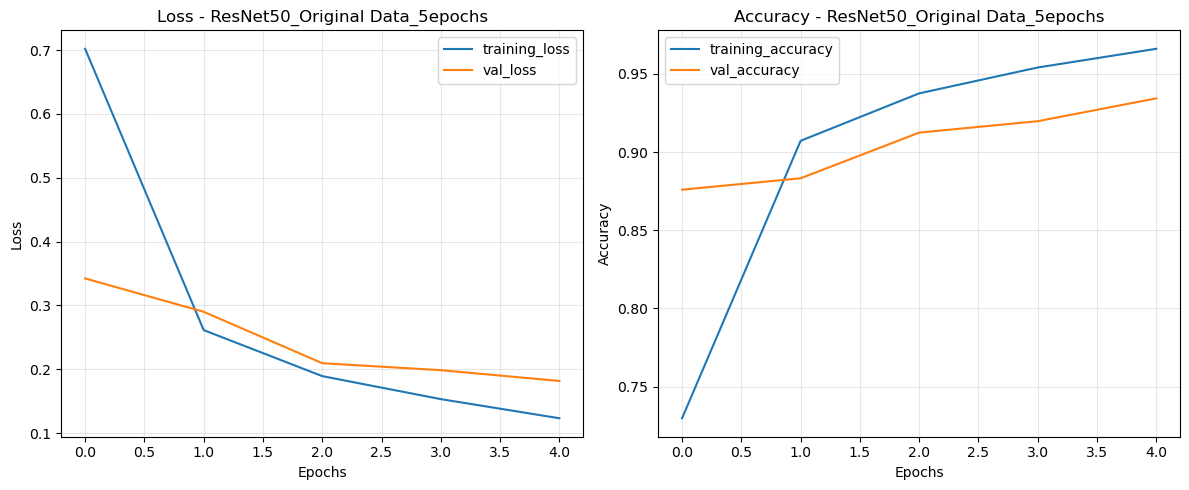

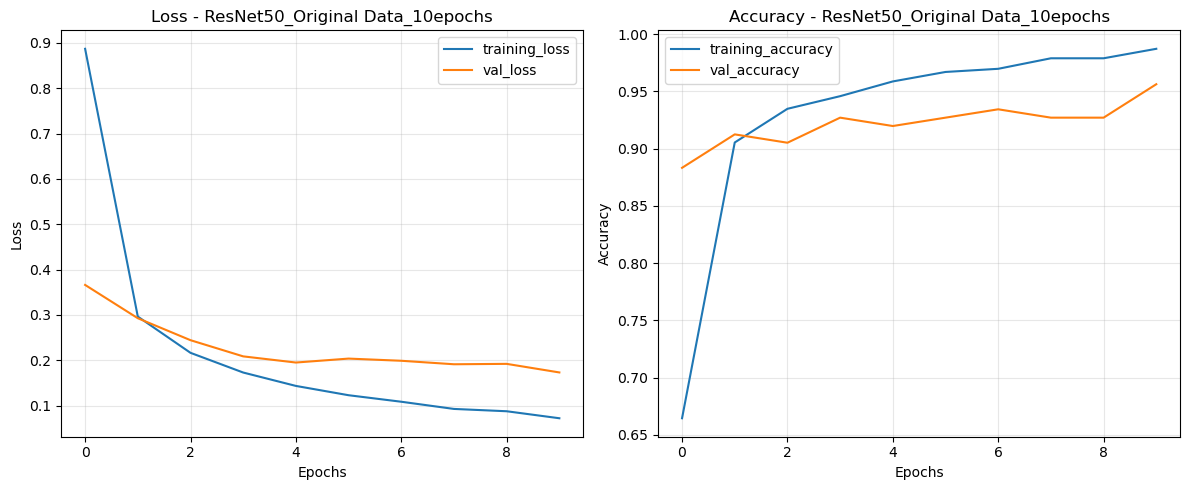

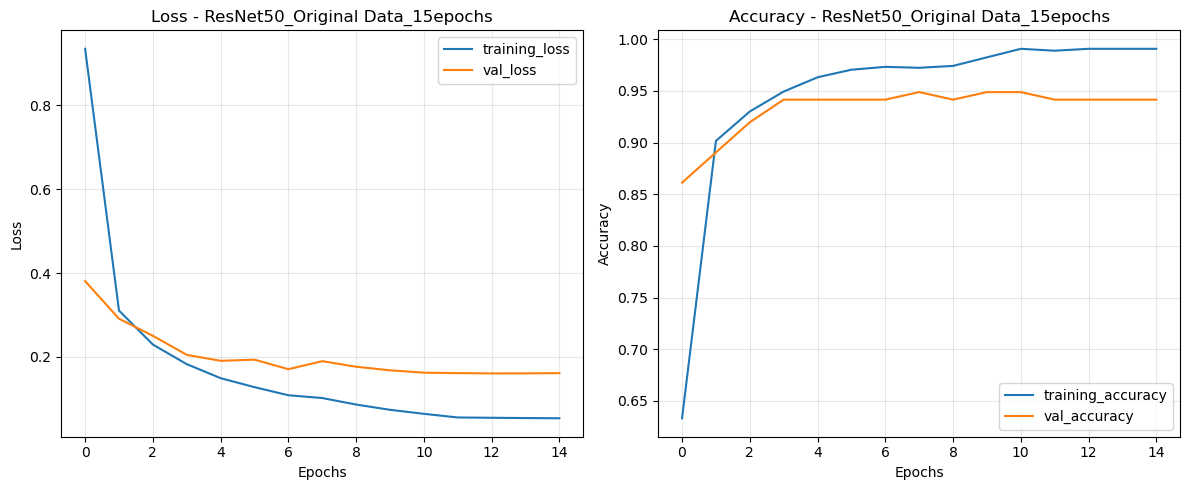

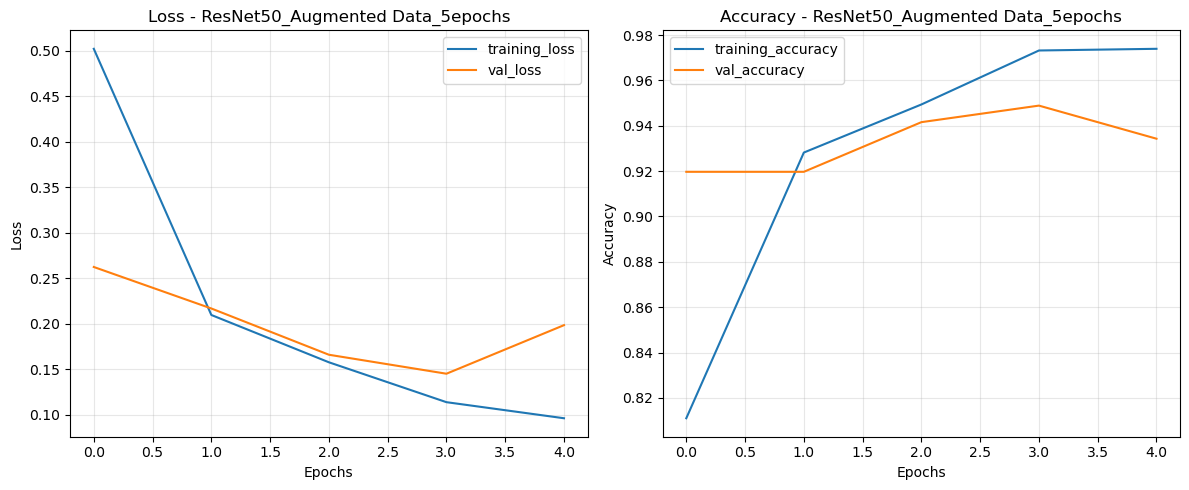

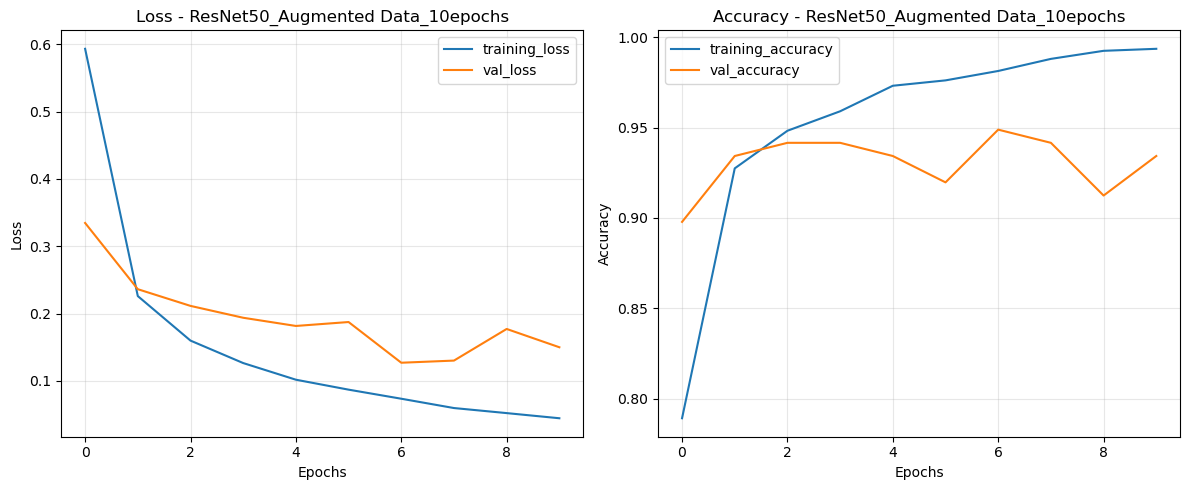

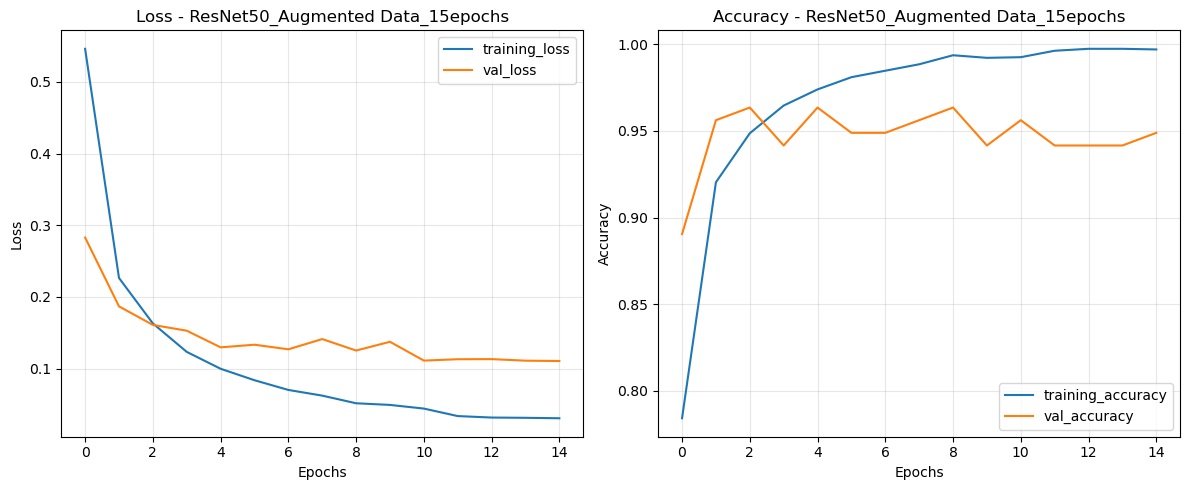

In [35]:
res50_dir = 'Publication_Exp_Logs/Res50_exp_logs.pkl'

plot_loss_curves_separate_figures(res50_dir,
                                 model_name='ResNet50')

* **10 epochs on the Original dataset is the best model for ResNet50**
* Train Accuracy is: 98.71% and validation Accuracy is 95.62%

### 7.2 For EfficientNetB0

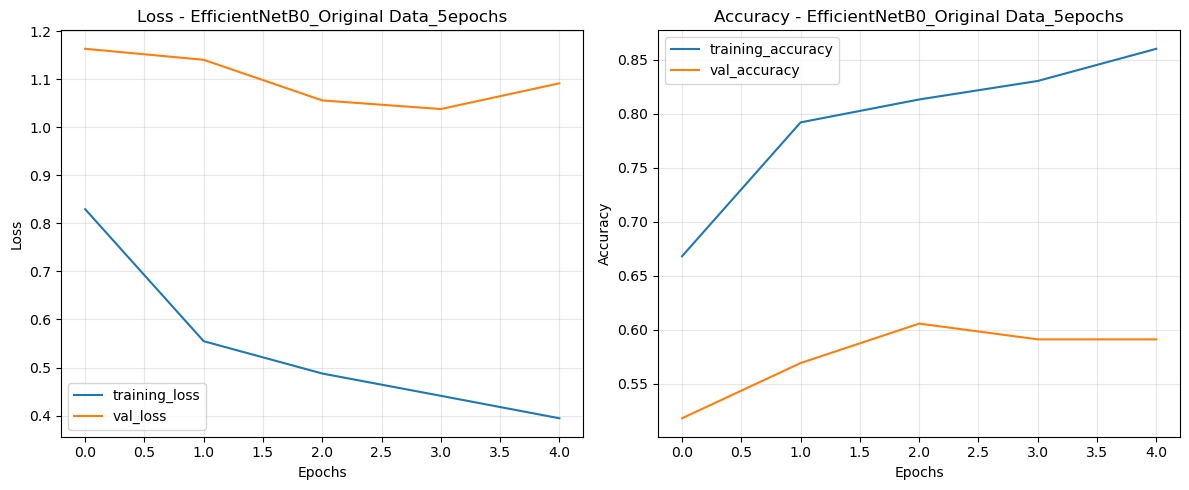

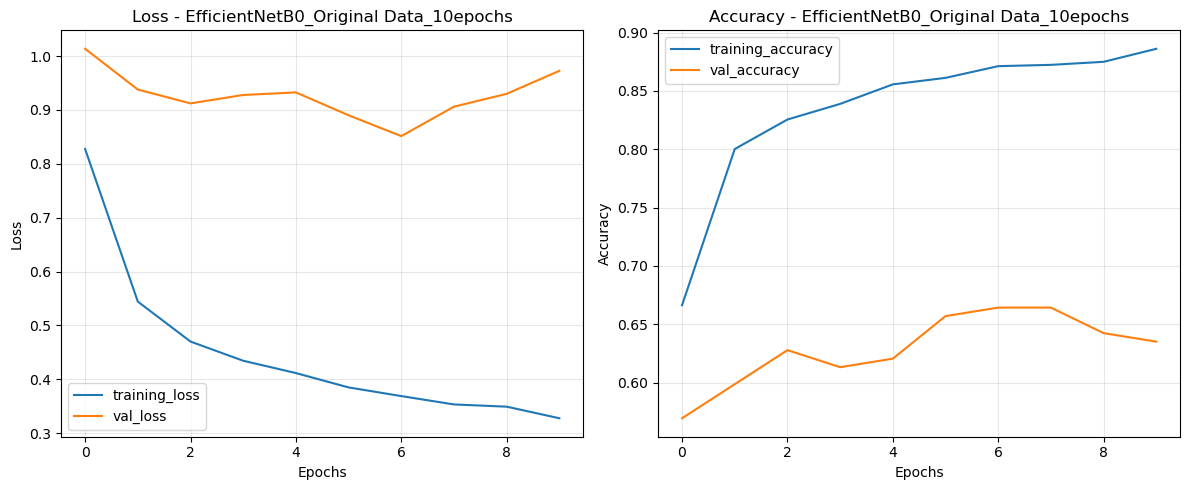

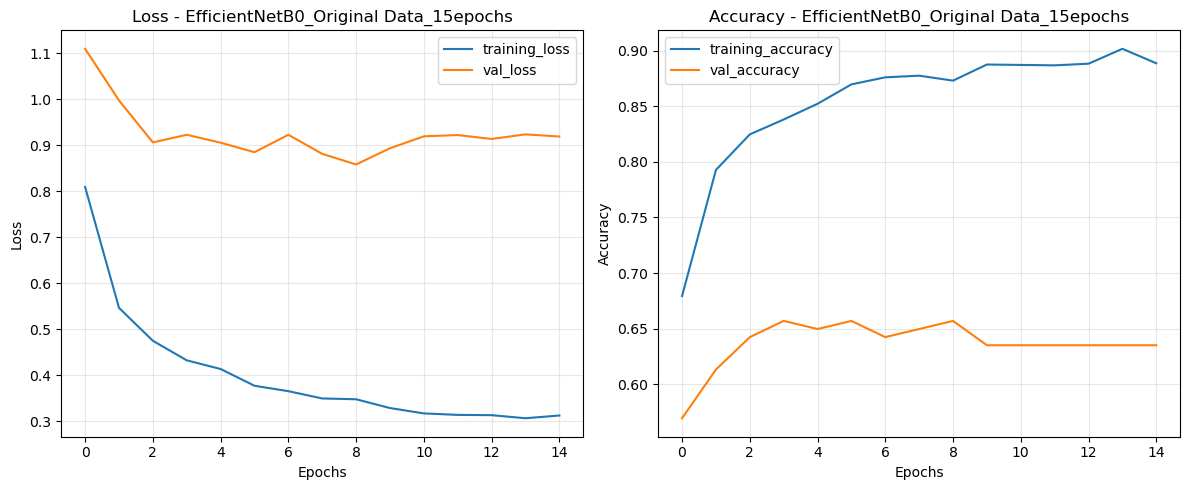

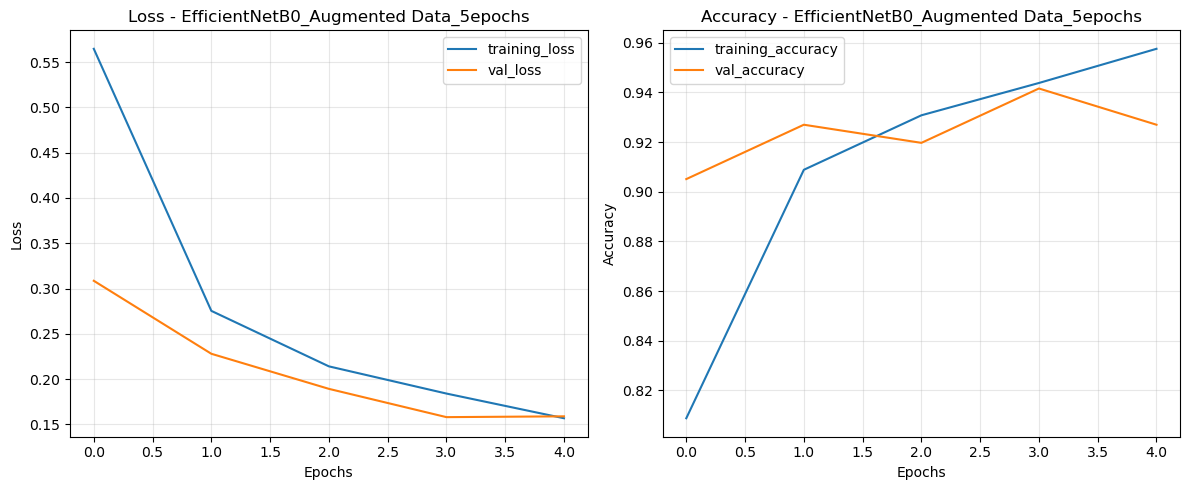

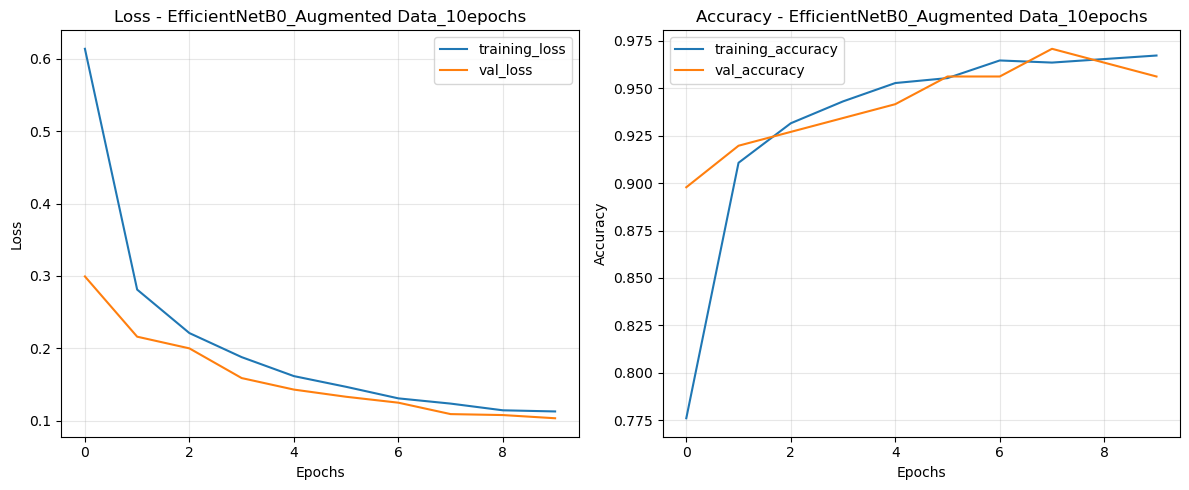

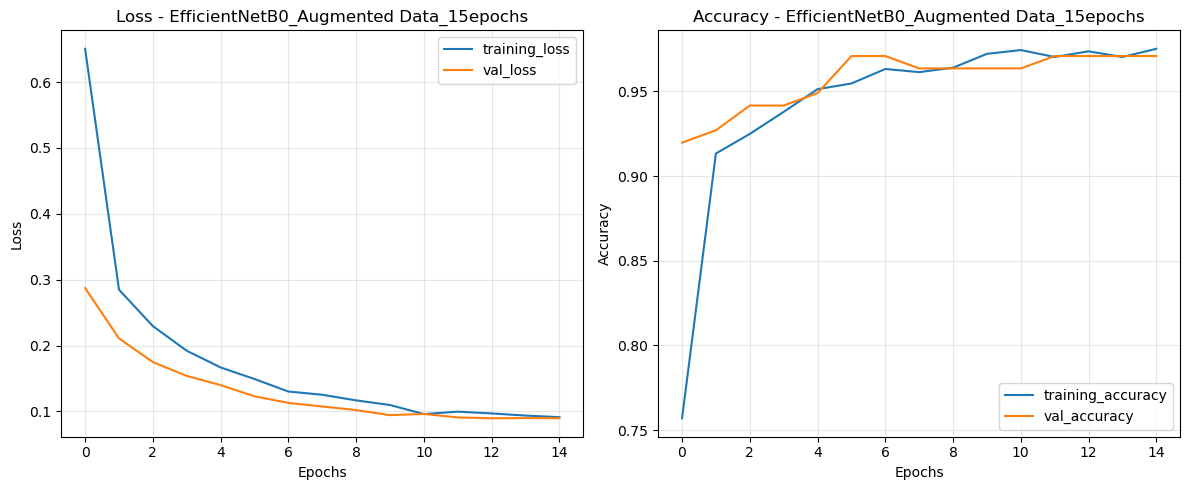

In [36]:
effnetb0_dir = 'Publication_Exp_Logs/Effnetb0_exp_logs.pkl'

plot_loss_curves_separate_figures(effnetb0_dir,
                                 model_name="EfficientNetB0")

* **15 epochs on the Augmented dataset is the best model for EfficientNetB0**
* Train Accuracy is: 97.51% and validation Accuracy is 97.08%

### 7.3 For EfficientNetB2

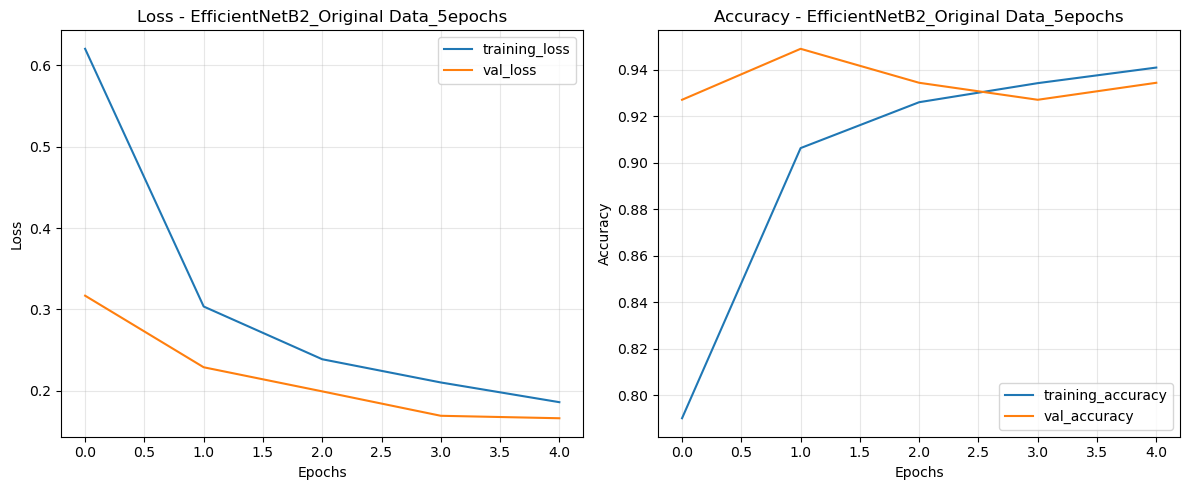

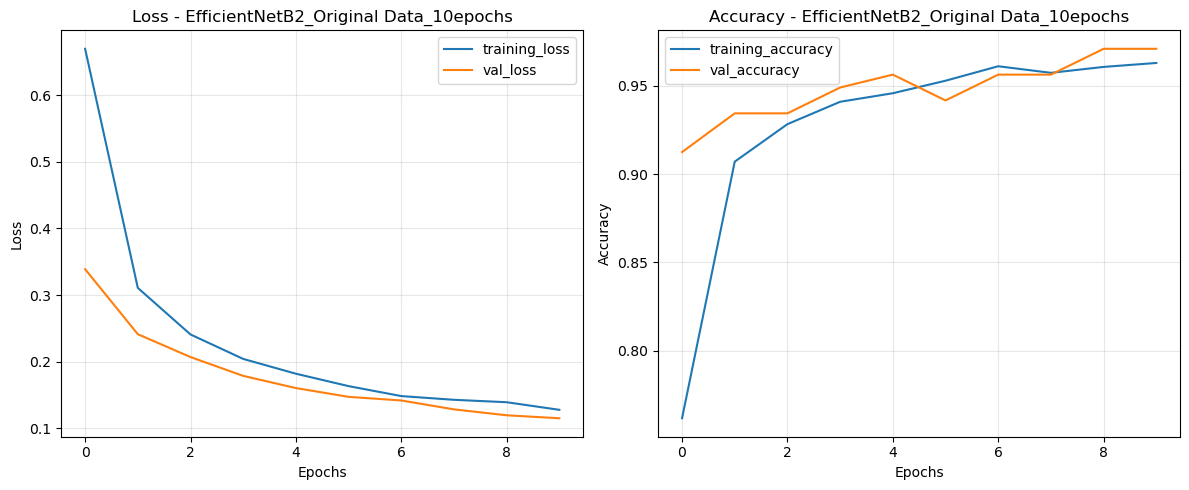

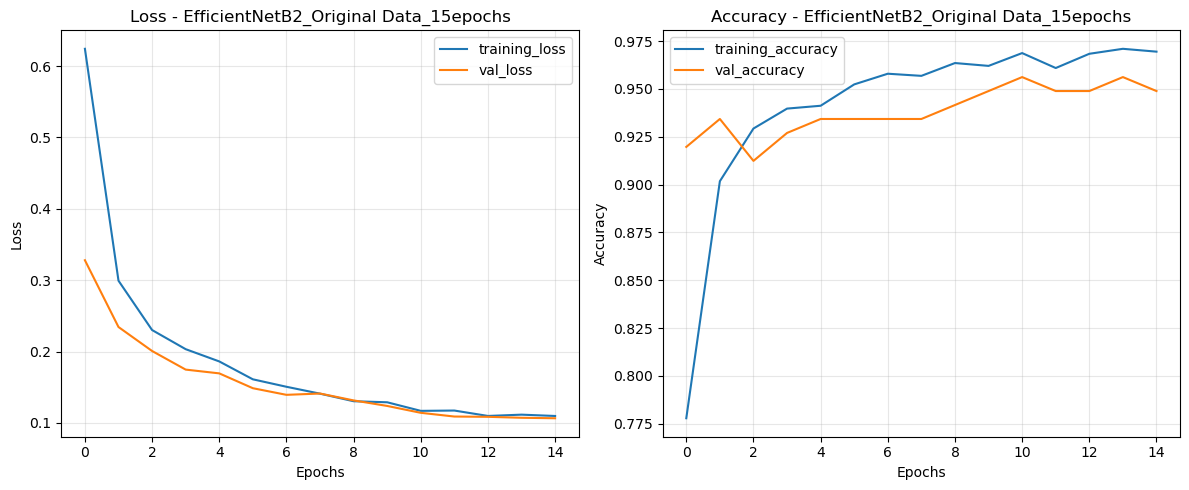

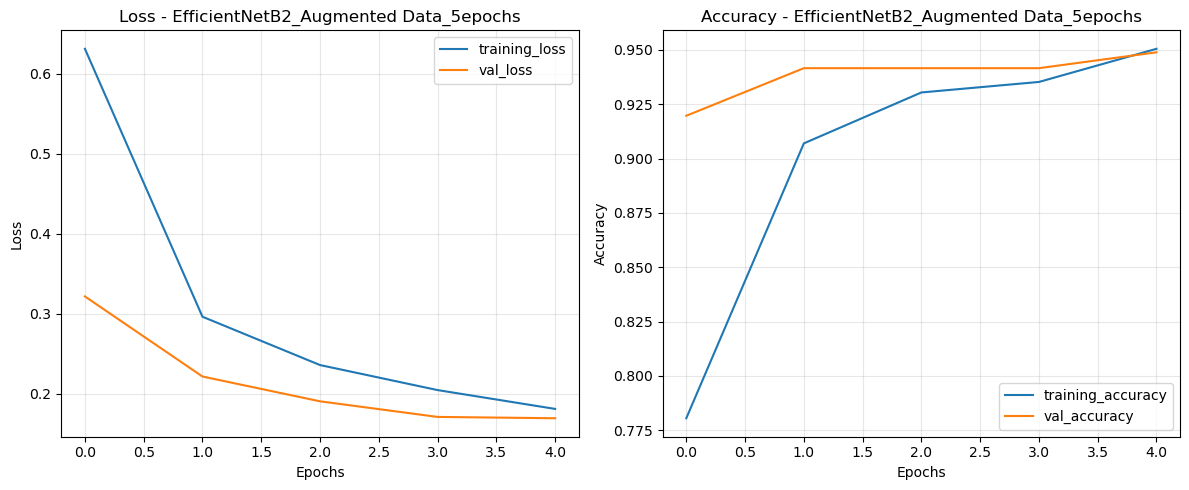

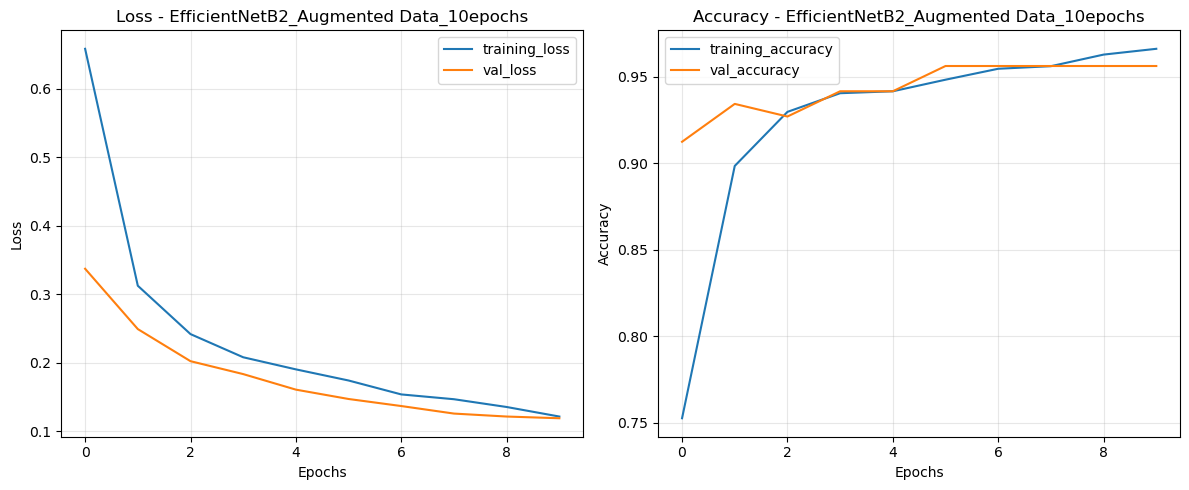

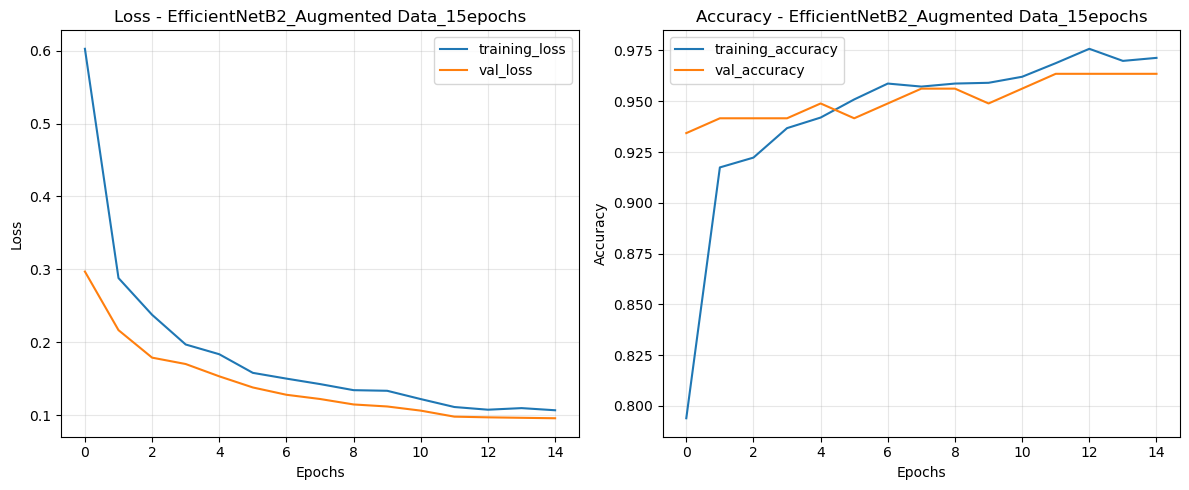

In [37]:
effnetb2_dir = 'Publication_Exp_Logs/Effnetb2_exp_logs.pkl'

plot_loss_curves_separate_figures(effnetb2_dir,
                                 model_name="EfficientNetB2")

* **15 epochs on the Augmented dataset is the best model for EfficientNetB2**
* Train Accuracy is: 97.14% and validation Accuracy is 96.35%

### 7.4 for MobilenetV2

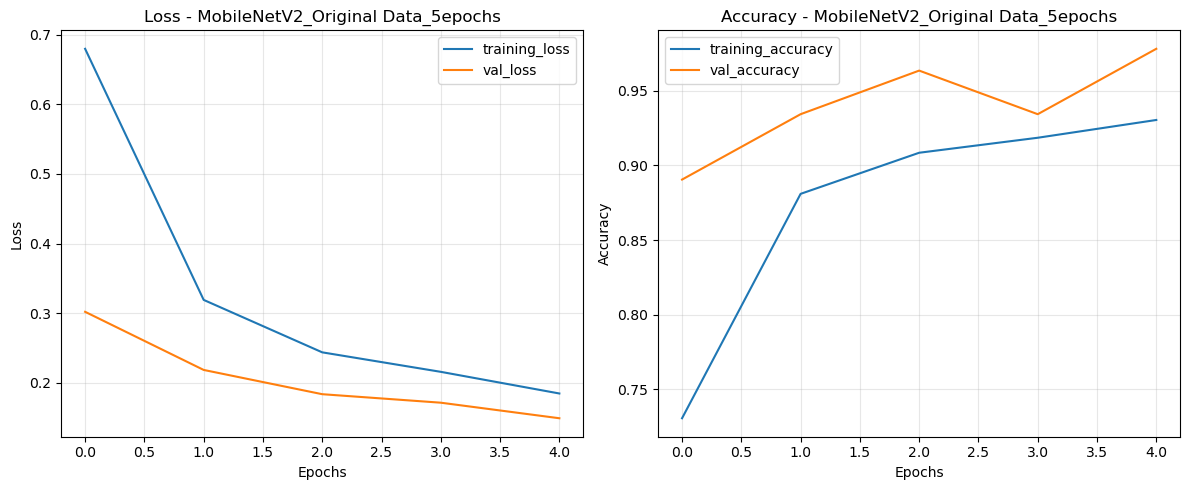

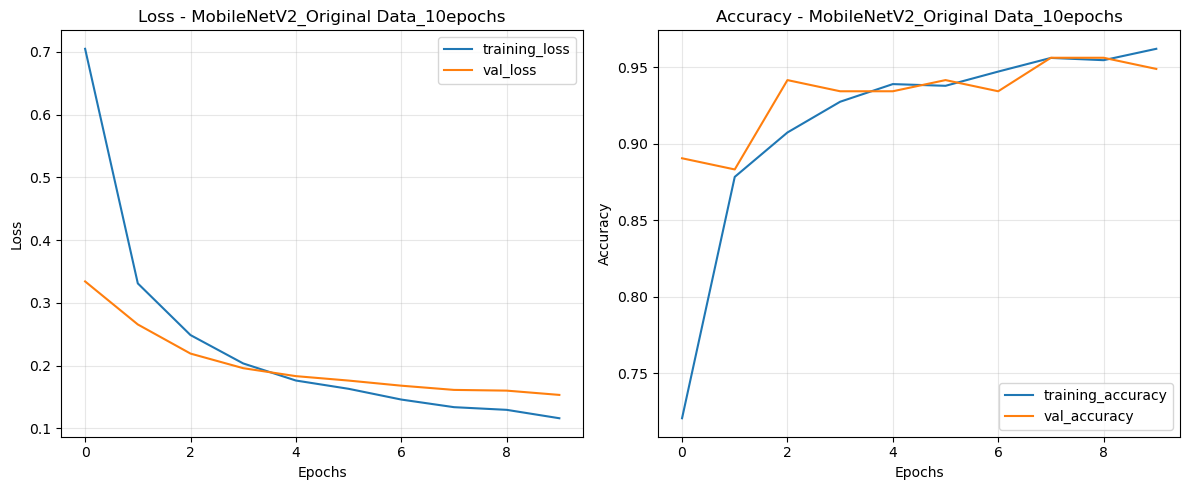

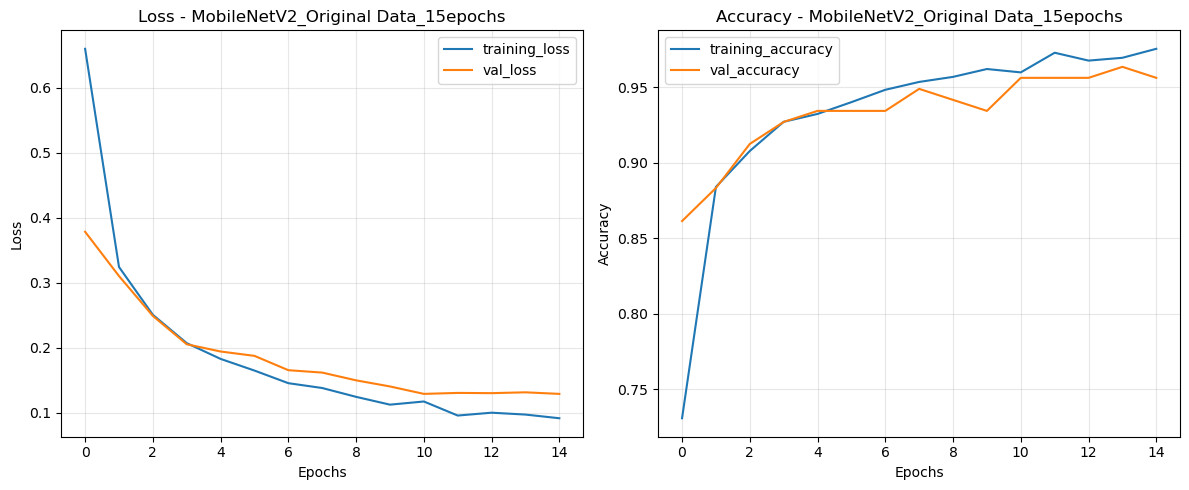

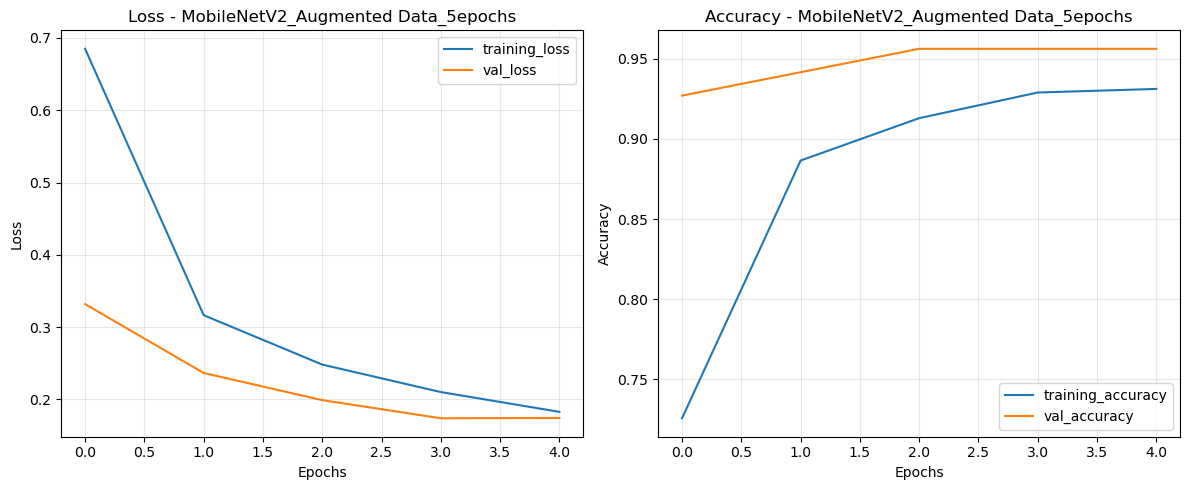

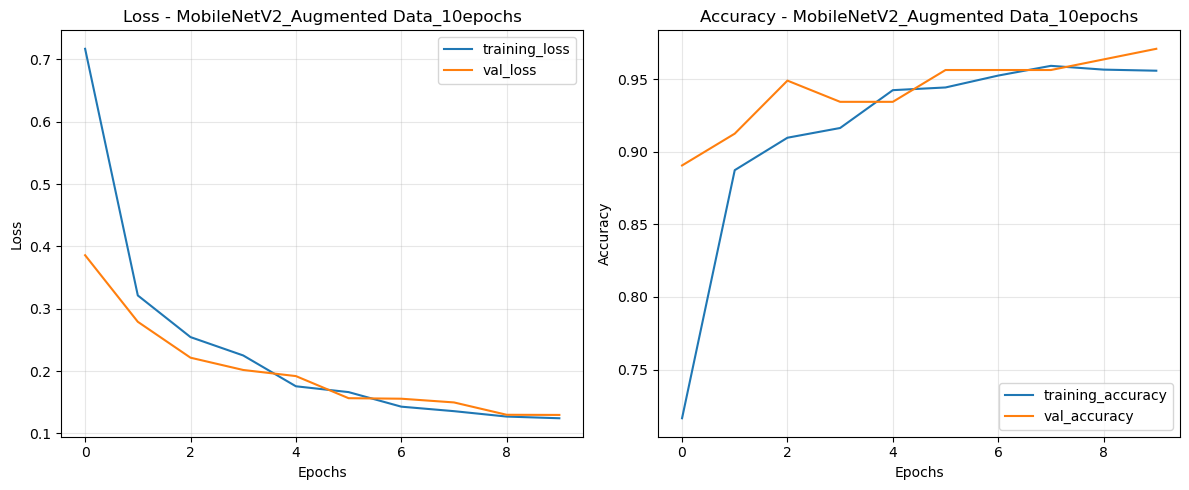

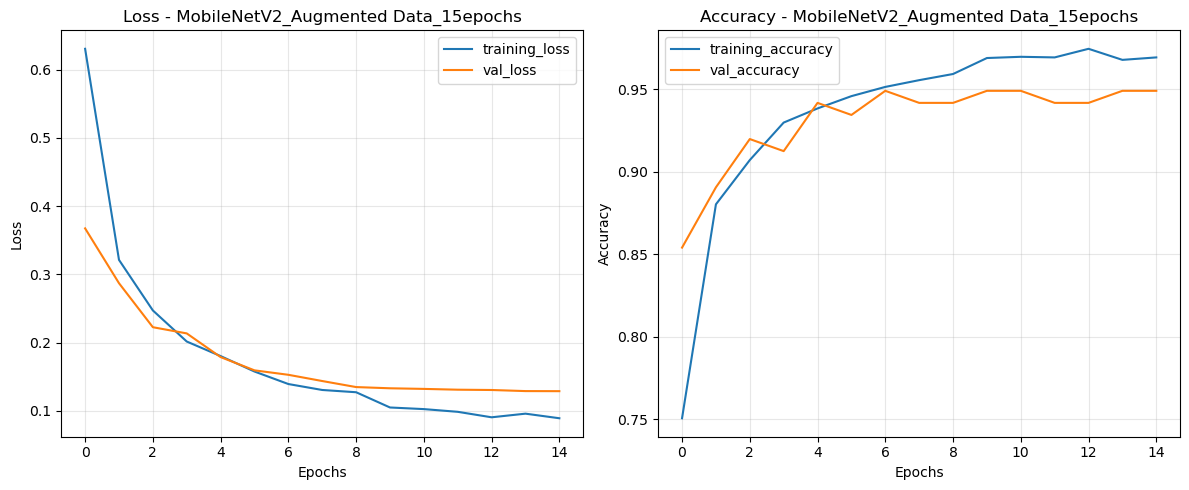

In [38]:
mobile_dir = 'Publication_Exp_Logs/MobilenetV2_exp_logs.pkl'

plot_loss_curves_separate_figures(mobile_dir,
                                 model_name=MobileNetV2)

* **10 epochs on the Origonal dataset is the best model for MobileNetV2**
* Train Accuracy is: 96.21% and validation Accuracy is 94.89%